
We will be analyzing blood cell images! There will be 3 classes: basophil, eosinophil, and neutrophil using a convolutional neural network to classify these images as accurately as possible.

## Load and Preprocess Image Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random

Class indices:

In [ ]:
classes = ["basophil", "eosinophil", "neutrophil"]
class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}

Gather filenames and shuffle.



In [ ]:
file_path = "/content/drive/MyDrive/bloodcells_dataset/"     # make sure it ends with bloodcells_dataset/ so we can access the different subfolders
baso = [f for f in listdir(file_path + "basophil") if isfile(join(file_path + "basophil", f)) and f != ".DS_Store"]
eosi = [f for f in listdir(file_path + "eosinophil") if isfile(join(file_path + "eosinophil", f)) and f != ".DS_Store"]
neutro = [f for f in listdir(file_path + "neutrophil") if isfile(join(file_path + "neutrophil", f)) and f != ".DS_Store"]
data = baso + eosi + neutro
random.shuffle(data)

Build a class called `BloodCell_Dataset`, a subclass of PyTorch's `torch.utils.data.Dataset`. All subclasses need to define 3 methods: `__init__()`, `__len__()`, and `__getitem__()`.


*   `__init__()`: Takes in the file path of the image folders, the list of file names we just gathered, and one of two modes - `train` or `test`. If the mode is `train`, then we will create the training test. If the mode is `test`, the entire testing data will be fetched at once to save time as we don't have that many testing images.
*   `__len__()`: Returns the length of the dataset, # of samples.
*   `__getitem__()`: Gets an input `i` and returns a tuple of `(data[i], label[i])`. In this method, we will only read the image from the disk every time a sample is requested. This helps us save an enourmous amount of space and can ensure CUDA out of memory errors never happening. This method also does some quick preprocessing, it makes sure that all images are of size `(3, 363, 360)`.

Fetch in batches to avoid running out of memory since these are high resolution images.



In [ ]:
class BloodCell_Dataset(Dataset):
    def __init__(self, file_path, file_path_list, mode="train", test_size=0.2):
        self.file_path = file_path
        self.classes = ["basophil", "eosinophil", "neutrophil"]
        self.class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
        self.idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}
        self.data = file_path_list
        assert mode in ['train', 'test'], f'mode needs to be either train or test, but it\'s {mode}'
        partition = int(len(self.data) * (1 - test_size))
        if mode == 'train':
            self.data = self.data[:partition]
        else:
            self.data = self.data[partition:]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)                                # if we're creating the test set, we can just fetch all images
                if len(img.shape) == 3:                                         # at once because the test set size is usually much smaller
                    img = img.unsqueeze(0)                                      # of course this may not ALWAYS be the case...
                self.tensor_imgs.append(img)
                self.labels.append(label.item())

            self.tensor_imgs = torch.cat(self.tensor_imgs, dim=0).type(torch.float32)
            self.labels = torch.tensor(self.labels).type(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        file_name = self.data[i]

        if "SNE" in file_name or "NEU" in file_name or "BNE" in file_name:      # each file name tells us whether the image is class 0, 1, or 2
            label = 2                                                           # so that's how we keep track of our labels
        elif "EO" in file_name:
            label = 1
        elif "BA" in file_name:
            label = 0

        convert_tensor = transforms.ToTensor()
        path = self.file_path + self.idx2class[label] + "/" + file_name
        img = Image.open(path)
        tensor_img = convert_tensor(img)                                        # converts image to 3D torch.Tensor
        if tensor_img.shape != (3, 363, 360):
            tensor_img = tensor_img[:, 3:366, 3:363]                            # quick crop and reshape if the image is not uniform
        return tensor_img.type(torch.float32), torch.tensor(label).type(torch.long)

    def get_test(self):
        return self.tensor_imgs, self.labels

Use the class we wrote to create 2 datasets. The creation of `testing_data` will take slightly longer because we are fetching the entire testing set into our memory. This method should take approximately 1 minute.

In [ ]:
training_data = BloodCell_Dataset(file_path, data, mode='train')
testing_data = BloodCell_Dataset(file_path, data, mode='test')

Let's look at the training and testing set size...

In [ ]:
print(f"Size of training_data:\t{len(training_data)}")
print(f"Size of testing_data:\t{len(testing_data)}")

Size of training_data:	390
Size of testing_data:	98


Inspect the dimension before we start building our model.

In [ ]:
test, test_label = testing_data.get_test()
print(test.shape)
print(test_label.shape)

torch.Size([98, 3, 363, 360])
torch.Size([98])


Now, our images are all of size `(3, 363, 360)`. Images have 3 channels (RGB channels) with height of 363 pixels and width of 360 pixels. PyTorch prefers the number of channels in the first dimension (second dimension if we include batch size, such as `(N, 3, 363, 360)`).

Visualize data!

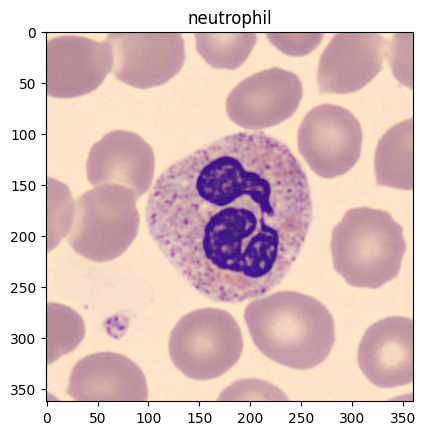

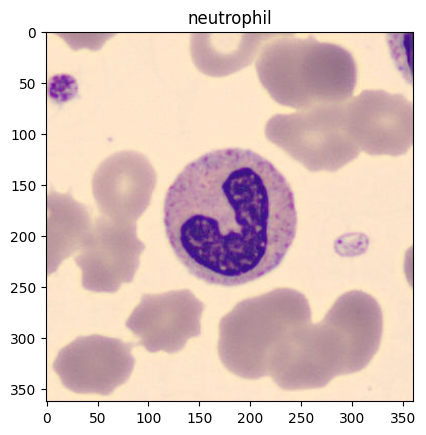

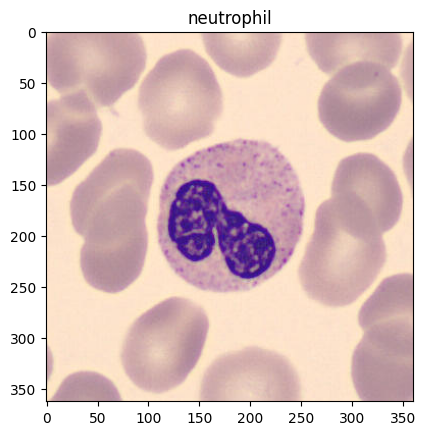

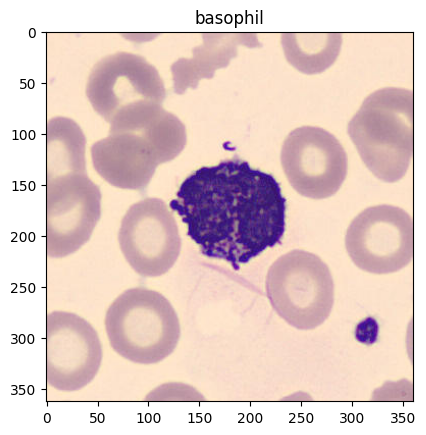

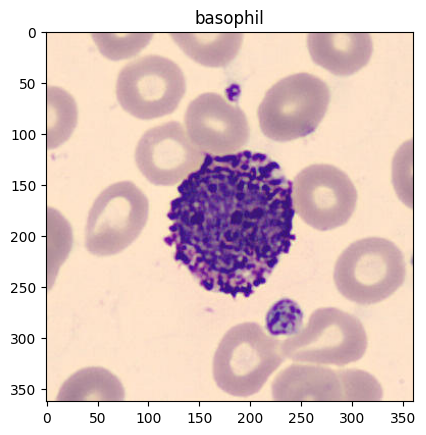

In [ ]:
def graph_cell(img, label, memo=""):
    """
    img: a torch.Tensor or a np.ndarray
    label: an integer
    """
    if type(img) == torch.Tensor:
        img = img.detach().cpu().numpy().squeeze()
    img = np.transpose(img.squeeze(), (1, 2, 0))
    plt.imshow(img)
    plt.title((idx2class[label]) + memo)
    plt.show()

for i in range(5):
    img, label = training_data[i]
    graph_cell(img, label.item())

## Convolutional Neural Network
In this section, we will begin creating our neural network architectures.

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


Design CNN architecture.

When designing a CNN, keep track of the dimensions after every layer. Print out the output shape while you're coding up your `forward()` and `__init__()` function.

In [ ]:
class BloodCell_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        """
        Define your layers here.
        """
        # Input shape = (3 RGB channels, 363 height, 360 width)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 4)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)

        # Max pooling layer 2x2
        self.max_pool = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)


        # Fully connected layers
        self.fc1 = nn.Linear(256 * 20 * 20, 256)  # Adjusted for image size after conv/pooling
        self.fc2 = nn.Linear(256, 3)  # Output classes

        # Dropout for regularization
        self.dropout = nn.Dropout(0.6)


    def forward(self, X):

        """
        Design the process of your network.
        """

        if len(X.shape) == 3:            # if one single image is passed, make sure it's of dimension (1, 3, H, W)
            X = X.unsqueeze(0)

        if X.max() <= 1.0:  # Only scale if necessary
            X = X * 255
        # Apply convolutions and ReLU activation
        X = self.max_pool(F.relu(self.bn1(self.conv1(X))))
        X = self.max_pool(F.relu(self.bn2(self.conv2(X))))
        X = self.max_pool(F.relu(self.bn3(self.conv3(X))))
        X = self.max_pool(F.relu(self.bn4(self.conv4(X))))

        # Flatten before passing to the fully connected layer
        X = torch.flatten(X, start_dim=1)

        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        logits = self.fc2(X)

        return logits   # do not apply softmax

    def classify(self, X):

        """
        Write a function that outputs the labels.
        """
        X = X.clone().detach().type(torch.float32)     # enforce smooth-running with the model
        logits = self(X)
        softmax = F.softmax(logits, dim=1) # returns vector with (754, )
        labels = torch.argmax(softmax, dim=1) # takes maximum probability within vector and returns index which equals classification label
        return labels.type(torch.long)



*   Send data to the device we are running the model on like so `x = x.to(device)` where device is what we specified earlier, either CUDA (GPU) or CPU. The things you need to send to the device include the data and the model.
*   When you want to transform your tensor to NumPy, you need to make sure that your tensor is no longer part of the "gradient descent" mechanism and back on the CPU. `x = x.detach().cpu().numpy()` (easily understand where the location of  tensors are).
*   Implement an early stopping or fall-back technique. Once model starts to overfit or plateau, set the model to the iteration when it had the highest validation accuracy. Python's `copy` package is of great use here. Every time a new accuracy is reached, save that iteration's model weights. At the end of the function, reset the model to that set of "best weights."


In [ ]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train(model, training_data, testing_data, epochs=15, batch_size=16, lr=1e-3):
    """
    Q:  write the training loop following the schema shown above.

    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - X_train, y_train, X_val, y_val: training and validation data
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate
    - optimizer: optimizer used

    Outputs
    - losses: a list of losses
    - accuracies: a list of accuracies
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    torch.cuda.empty_cache()
    model = model.to(device)

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)          # it's already shuffled

    testing_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

    best_acc = -1
    best_model = None

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        for imgs, labels in iter(train_dataloader):         # check what imgs, labels look like
            imgs, labels = imgs.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Reset gradients
            outputs = model(imgs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_dataloader))  # Average loss for the epoch

        # Switch to evaluation mode for validation
        model.eval()

        # Validate on testing data
        with torch.no_grad():
            all_preds = []
            all_labels = []

            for test_imgs, test_labels in iter(testing_dataloader):
                test_imgs = test_imgs.to(device)
                pred_labels = model.classify(test_imgs)

                # Move predictions to CPU and convert to NumPy
                pred_labels = pred_labels.detach().cpu().numpy()
                test_labels = test_labels.numpy()

                all_preds.extend(pred_labels)
                all_labels.extend(test_labels)

            # Calculate validation accuracy

            accuracy = accuracy_score(all_labels, all_preds)
            accuracies.append(accuracy)

        if accuracy > best_acc:     # implement the fall-back technique mentioned in the description
            best_acc = accuracy
            best_model = deepcopy(model)

        # print epoch, loss, and current test accuracy (don't delete this line - it's slightly more organized now)
        print(f"Epoch {epoch + 1}:\tloss {np.round(loss.detach().cpu().numpy().item(), 4)}\t& accuracy {np.round(accuracy, 4)}")
    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")
    model.load_state_dict(best_model.state_dict())
    return losses, accuracies

Train our model.

Target accuracy: 80%

In [ ]:
model = BloodCell_CNN()
losses, accuracies = train(model, training_data, testing_data, batch_size=16, epochs=7)

Epoch 1:	loss 1.2679	& accuracy 0.2653
Epoch 2:	loss 0.0698	& accuracy 0.8265
Epoch 3:	loss 0.0956	& accuracy 0.9286
Epoch 4:	loss 0.069	& accuracy 0.8265
Epoch 5:	loss 0.0564	& accuracy 0.7449
Epoch 6:	loss 0.0201	& accuracy 0.9184
Epoch 7:	loss 0.0348	& accuracy 0.949
Resetting model... Best validation accuracy:	0.949


Plot our predictions! If the model learned well, it should correctly classify all images besides the first one or even better. Prediction of the model and the actual label of the slide is included.

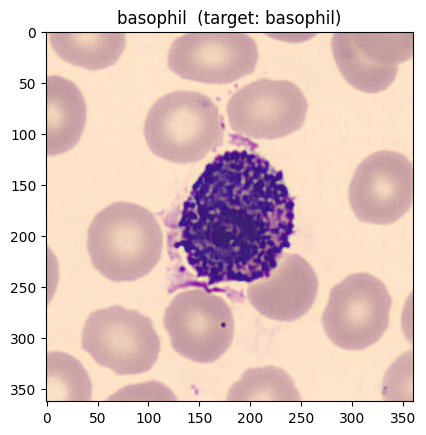

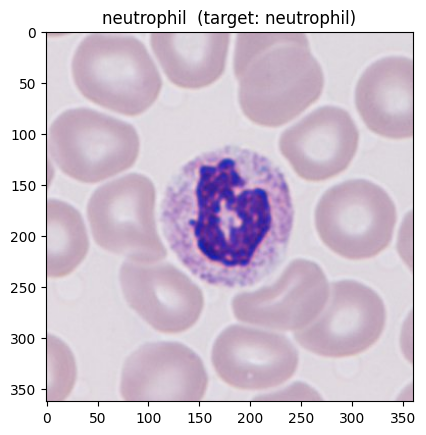

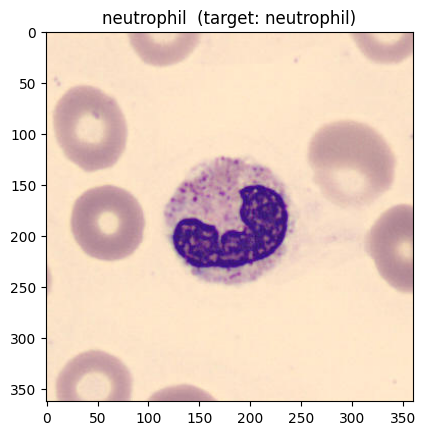

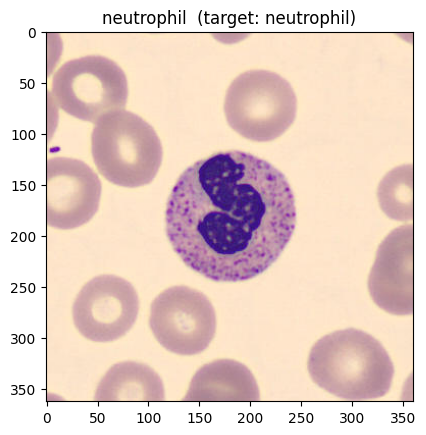

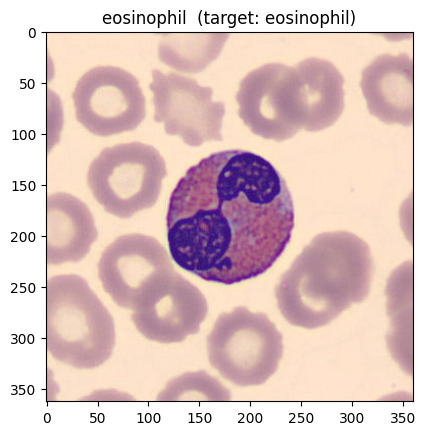

In [ ]:
torch.cuda.empty_cache()
imgs = testing_data.tensor_imgs[:5]
labels = testing_data.labels[:5]
preds = model.classify(imgs.to(device))
for i in range(5):
    graph_cell(imgs[i], preds[i].item(), memo=f"  (target: {idx2class[labels[i].numpy().item()]})")

Save the model.

In [ ]:
torch.save(model.state_dict(), file_path + "my_model.pt")       # save your model - do NOT change the name of
                                                                   # the model or else the autograder won't recognize it!

## Generate Predictions

Once you're done with your model training, edit the `test_path` in the following cell and it should generate a list of predictions.

In [ ]:
# empty some RAM
torch.cuda.empty_cache()
del testing_data
del training_data

test_path = "/content/drive/MyDrive/bloodcells_dataset/test_data.npy"

test = np.load(test_path)
test = torch.tensor(test).type(torch.float32).to(device)
test = test.permute(0, 3, 1, 2)

# split the hidden test data in half to avoid GPU memory problems
preds1 = model.classify(test[:71])
preds1 = preds1.detach().cpu().numpy()
torch.cuda.empty_cache()
preds2 = model.classify(test[71:])
preds2 = preds2.detach().cpu().numpy()
preds = np.concatenate([preds1.flatten(), preds2.flatten()])
np.save("/content/drive/MyDrive/predictions.npy", preds)
print("Predictions saved!")

Predictions saved!


Short questions:


1.   What special features did you add to your network? What worked and didn't work?
2.   Describe how we combatted the problem of feeding too much data into the memory and causing a CUDA out of available memory error.

Your answers:

1.  I added 4 convolutional filters with batch normalization after each filter with a kernel of size 4x4. I then used two fully connected layer and a dropout layer with probability = 6 to increase regularization and reduce overfitting. My model did not originally work with only three filters and a kernel size of 3x3. The four filters also didn't work when I only used batch normalization after three of the filters.
2.   We combatted a memory error by creating dataset class to handle fetching images during training. The __getitem__() method allows us to only read the image from the disk every time a sample is requested, rather than reading through all the data every single time, which saves an enourmous amount of space and ensures CUDA doesn't run into memory errors.


